In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from math import log2, log10
import pickle
import cobra
from glob import glob
import numpy as np
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline

/home/sbrg-cjlloyd/cobrapy/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


In [2]:
met_to_name = {'2dmmq8': '2-Demethyl-\nmenaquinone 8',
 '2fe2s': '2Fe-2S',
 '4fe4s': '4Fe-4S',
 'adocbl': 'Adenosyl-\ncobalamin',
 'ala__L': 'L-Alanine',
 'arg__L': 'L-Arginine',
 'asn__L': 'L-Asparagine',
 'asp__L': 'L-Aspartate',
 'bmocogdp': 'bis-MGD',
 'btn': 'Biotin',
 'coa': 'Coenzyme A',
 'cys__L': 'L-Cysteine',
 'gln__L': 'L-Glutamine',
 'glu__L': 'L-Glutamate',
 'gly': 'Glycine',
 'gthox': 'Glutathione',
 'hemeO': 'Heme O',
 'his__L': 'L-Histidine',
 'ile__L': 'L-Isoleucine',
 'leu__L': 'L-Leucine',
 'met__L': 'L-Methionine',
 'mqn8': 'Menaquinone 8',
 'nac': 'Niacin',
 'nad': 'NAD',
 'nadp': 'NADP',
 'phe__L': 'L-Phenylalanine',
 'pheme': 'Protoheme',
 'pnto__R': 'Pantothenate',
 'pro__L': 'L-Proline',
 'pydx5p': "Pyridoxal \n 5'-phosphate",
 'pydxn': "Pyridoxine",
 'q8': 'Ubiquinone-8',
 'ribflv': 'Riboflavin',
 'ser__L': 'L-Serine',
 'sheme': 'Siroheme',
 'thf': 'Tetrahydrofolate',
 'thmpp': 'Thiamine \n diphosphate',
 'thm': 'Thiamin', 
 'thr__L': 'L-Threonine',
 'trp__L': 'L-Tryptophan',
 'tyr__L': 'L-Tyrosine',
 'val__L': 'L-Valine'}

In [3]:
with open('/home/sbrg-cjlloyd/multime/multime/iJL1678b_ML_keffs.pickle', 'rb') as f:
    me = pickle.load(f)

In [4]:
mets_to_skip = ['glu__L', 'gln__L', 'asn__L', 'arg__L', 'thr__L', 'skm']

In [5]:
from optaux.resources.update_mpl_rcparams import update_rcparams
update_rcparams()
plt.rcParams['figure.figsize'] = [15.0, 5.0]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

In [6]:
aas = ['met__L', 'ser__L', 'phe__L', 'asn__L', 'thr__L',
       'ile__L', 'asp__L', 'trp__L', 'cys__L', 'ala__L', 
       'glu__L', 'gln__L', 'arg__L', 'leu__L', 'pro__L', 
       'val__L', 'lys__L', 'gly', 'tyr__L', 'his__L']

In [7]:
for kind in ['fluxes']:
    joined = pd.DataFrame()
    for file in glob('./titration/%s.csv' % kind):
        df = pd.read_csv(file, index_col=0)
        joined = joined.join(df, how='outer')
cons_df = joined.T[~ joined.columns.isin(['default'])].T
default_series = joined['default']

cons_df = cons_df.T
cons_df.index.name = 'metabolite'


In [8]:
df = cons_df.reset_index()
for i in df.index:
    df.loc[i, 'uptake'] = float(df.loc[i, 'metabolite'].split('_')[-1])
    df.loc[i, 'metabolite'] = '_'.join(df.loc[i, 'metabolite'].split('_')[:-1])

In [9]:
def change_index_to_uptake_fraction(df):
    cons_pca_df = df.copy().T
    cons_pca_df['metabolite'] = list(cons_pca_df.index)
    cons_pca_df['uptake'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[-1]).map(float)
    cons_pca_df['metabolite'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[0])
    # Normalize to fraction of max uptake
    for i in cons_pca_df.metabolite.unique():
        met_index = cons_pca_df.index[cons_pca_df.metabolite == i]
        cons_pca_df.loc[met_index, 'uptake'] = cons_pca_df.loc[met_index, 'uptake'] / cons_pca_df.loc[met_index, 'uptake'].max()
    cons_pca_df['new_index'] = cons_pca_df['metabolite'] + '(' + cons_pca_df['uptake'].map(lambda x: round(x, 2)).map(str) + ')'
    cons_pca_df.set_index('new_index', inplace=True, drop=True)
    
    return cons_pca_df

In [10]:
def return_individual_comparison(temp_df, default_series, substrate=None, substrate_carbons=0, kind='growth', at_max=False):
    if at_max:
        temp_df = temp_df[temp_df.uptake == temp_df.uptake.max()]
    default_gr = default_series['biomass_dilution']
    if kind == 'growth':
        y = temp_df.biomass_dilution.values
        return y / default_gr
    elif kind == 'iron_uptake':
        uptake_activity = abs(temp_df['EX_fe3_e'] / temp_df['biomass_dilution'])    
        default_iron_uptake = abs(default_series['EX_fe3_e'] / default_gr)
        return abs(uptake_activity / default_iron_uptake)
    elif kind == 'glucose':
        gluc_uptake = abs(temp_df['EX_glc__D_e'] / temp_df['biomass_dilution'])
        default_gluc_uptake = abs(default_series['EX_glc__D_e'] / default_gr)
        return gluc_uptake / default_gluc_uptake
    elif kind == 'yield':
        y = temp_df.biomass_dilution.values
        gluc_uptake = abs(temp_df['EX_glc__D_e'])
        default_gluc_uptake = abs(default_series['EX_glc__D_e'])
        return (y/(gluc_uptake*6 + abs(temp_df[substrate] * substrate_carbons))) / (default_gr / default_gluc_uptake/6)
    
def return_protein_use_comparison(temp_df, default_series, kind='iron_complex_activity', at_max=False):
    if at_max:
        temp_df = temp_df[temp_df.uptake == temp_df.uptake.max()]
    if kind == 'num_proteins_expressed':
        # This a roundabout way of getting this value that was partially written
        # to compare overlap of invidual proteins, if needed
        
        # Get list of proteins active
        enzymes = []
        for i in temp_df.columns:
            if 'translation_' not in i:
                continue
            enzymes.append(i)
        ax = axes[2]  
        enzyme_activity = temp_df[enzymes]
        default_enzyme_activity = default_series[enzymes]

        enzyme_activity[enzyme_activity > 1e-20] = 1
        default_enzyme_activity[default_enzyme_activity > 1e-20] = 1
        default_enzymes_active = set(default_enzyme_activity[default_enzyme_activity == 1].index)
        num_shared = []
        num_different = []
        for i in enzyme_activity.index:
            num_shared.append(len(default_enzymes_active & 
                                  set(enzyme_activity.loc[i][enzyme_activity.loc[i] == 1].index)))
            num_different.append(-len(set(enzyme_activity.loc[i][enzyme_activity.loc[i] == 1].index).difference(
                    default_enzymes_active)))
        return (np.array(num_shared) - np.array(num_different)) / len(default_enzymes_active)
    elif kind == 'iron_enzyme_activity':
        # todo finish or remove
         # Get list of reactions forming complexes w/ iron cofactors
        iron_cofactors = ['mod_fe2', 'mod_pheme', 'mod_hemed', 'mod_4fe4s', 'mod_sheme',
                          'mod_3fe4s', 'mod_3fe4s', 'mod_2fe2s', 'mod_fe3', 'mod_NiFeCoCN2', 
                          'mod_hemeO']
        iron_enzymes = []
        for i in temp_df.columns:
            if 'formation_'  in i:
                continue
            for cofactor in iron_cofactors:
                if cofactor in i:
                    iron_enzymes.append(i)
    else:
        raise Exception('Not valid kind', kind)
ros_damage_probability = pd.read_excel('Table_S2_Bayes_R02.xlsx', index_col=1)['damaged']
def find_flux_through_ros_sensitive_protein(temp_df, default_series, ros_damage_probability, at_max=False):
    if at_max:
        temp_df = temp_df[temp_df.uptake == temp_df.uptake.max()]
    default_gr = default_series['biomass_dilution']
    # Get list of proteins active
    enzymes = []
    for i in temp_df.columns:
        if 'translation_' not in i or i.replace('translation_', '') not in ros_damage_probability:
            continue
        enzymes.append(i)
    damage_series = ros_damage_probability.rename(lambda x: 'translation_' + x)
    return (((temp_df[enzymes] * damage_series[enzymes]).T.sum() / (temp_df['biomass_dilution'])) / 
            ((default_series[enzymes] * damage_series[enzymes]).T.sum()/ default_gr))
    

In [11]:
def get_protein_distribution(model, solution=None, cog_df=None, groupby='COG'):
    """
    Return the synthesis flux for each protein.

    First implementation-can be improved
    """
    protein_dict = defaultdict(float)
    if not solution:
        solution = model.solution
    else:
        model.solution = solution
    ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/ecolime/ecolime/building_data/iJO1366.json')
    
    translation = model.get_translation_flux(solution=solution)

    if groupby == 'COG' and cog_df is not None:
        
        for protein, flux in translation.items():
            protein_mass = model.metabolites.get_by_id('protein_' + protein).formula_weight
            if protein != 'dummy':
                if protein in cog_df.index:
                    try:
                        cog = cog_df.loc[protein, 'COG description'].values[0]
                    except:
                        cog = cog_df.loc[protein, 'COG description']
                else:
                    cog = 'No COG'

                protein_dict[cog] += protein_mass * flux
            else:
                protein_dict['dummy'] += protein_mass * flux

    elif groupby == 'Metabolic_Subsystem':
        for protein_id, flux in translation.items():
            if flux <= 0:
                continue
            subsystem_dict = dict()
            protein = model.metabolites.get_by_id('protein_' + protein_id)
            protein_mass = protein.formula_weight
            met_fluxes = 0
            if protein_id not in ijo.genes:
                continue
            for r in ijo.genes.get_by_id(protein_id).reactions:
                if r.id not in me.process_data:
                    continue
                for me_rxn in me.process_data.get_by_id(r.id).parent_reactions:
                    # Flux is a function of keff, so account for that
                    if abs(me_rxn.x)>1e-10:
                        subsystem_dict[r.subsystem] = abs(me_rxn.x) / me_rxn.keff
                        met_fluxes += abs(me_rxn.x) / me_rxn.keff
            for sub, met_flux in subsystem_dict.items():
                protein_dict[sub] += protein_mass * flux * (met_flux/met_fluxes)
    else:
        raise Exception('groupby flag is not "COG" or "Metabolic_Subsystem')

    return protein_dict

# Plot global characteristic

btn


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:39 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3414 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


nac
pnto__R
pydxn
ribflv
thf
thm
his__L
leu__L
met__L
phe__L
trp__L
tyr__L


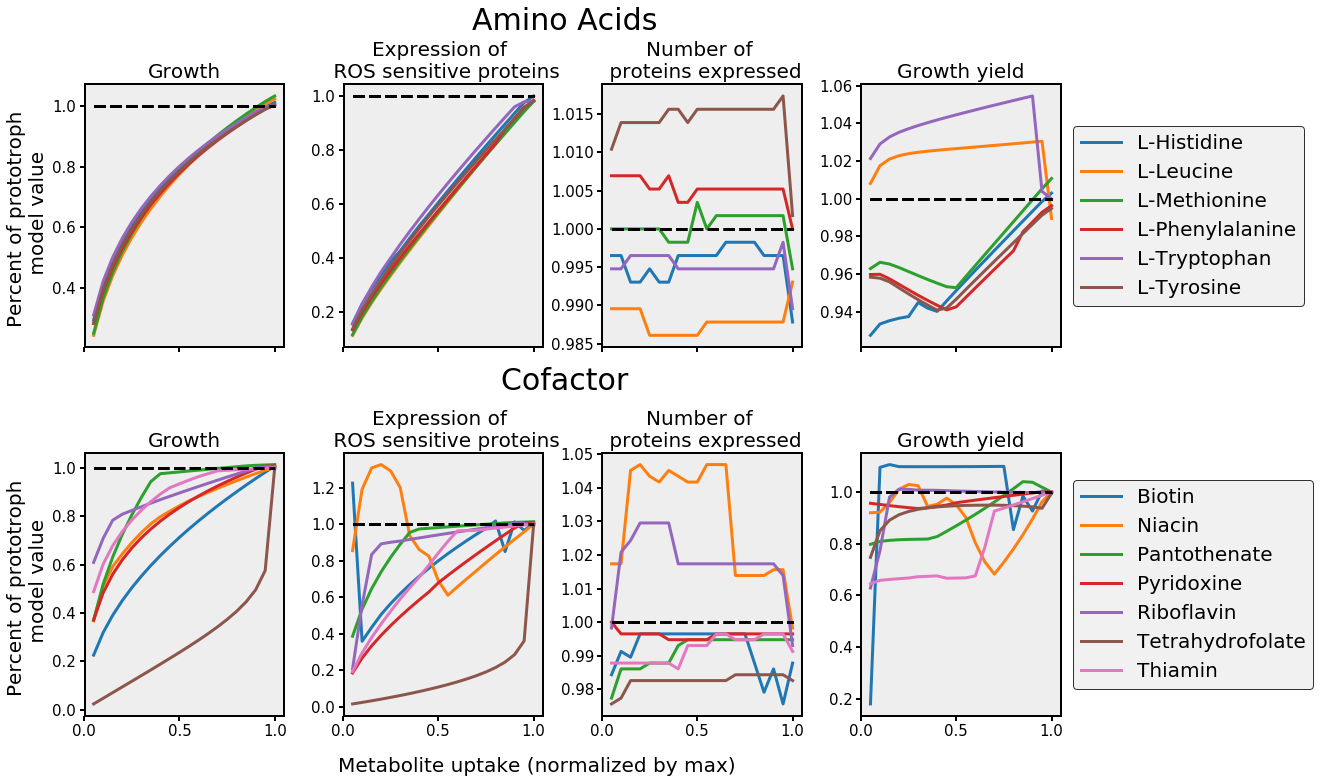

In [12]:
# W/ changing abundance
fig, all_axes = plt.subplots(2, 4, sharex=True, figsize=(15,10))

for kind in ['cofactors', 'aas']:
    for met, temp_df in df.groupby('metabolite'):
        if kind == 'aas' and met not in aas:
            continue
        elif kind == 'cofactors' and met in aas:
            continue
        #if met != 'thf' and met != 'phe__L':
        #    continue
        if met in mets_to_skip:
            continue
        if kind == 'aas':
            axes = all_axes[0]
        elif kind == 'cofactors':
            axes = all_axes[1]
        print(met)
        temp_df.uptake = temp_df.uptake.map(float)
        temp_df.biomass_dilution = temp_df.biomass_dilution.map(float)
        temp_df = temp_df.sort_values('uptake')

        # Plot growth rate
        x = (temp_df.uptake/ temp_df.uptake.max()).values
        ax = axes[0]
        ax.plot(x, return_individual_comparison(temp_df, default_series), label=met_to_name[met])
        ax.plot([1/20, 1], [1]*2, 'k--')
        ax.set_ylabel('Percent of prototroph \n model value')
        ax.set_title('Growth')
        #ax.set_ylim(bottom=.99)


        ax = axes[1]           
        ax.plot(x, find_flux_through_ros_sensitive_protein(temp_df, default_series, ros_damage_probability))
        ax.set_title('Expression of \n ROS sensitive proteins')
        ax.plot([1/20, 1], [1] *2, 'k--')
        #ax.set_ylim(bottom=.99)

        ax = axes[2]
        ax.plot(x, return_protein_use_comparison(temp_df, default_series, kind='num_proteins_expressed'), label=met_to_name[met])
        ax.set_title('Number of \n proteins expressed')
        ax.plot([1/20, 1], [1] *2, 'k--')

        ax = axes[3]  
        substrate_carbons = me.metabolites.get_by_id(met + '_c').elements['C']
        ax.plot(x, return_individual_comparison(temp_df, default_series, kind='yield', substrate='EX_'+met+'_c',
                                                substrate_carbons=substrate_carbons), label=met_to_name[met])
        ax.plot([1/20, 1], [1] *2, 'k--')
        ax.set_title('Growth yield')
    ax.legend(bbox_to_anchor=(1.01, .5), loc='center left')
    
fig.text(.5, -.03, 'Metabolite uptake (normalized by max)', ha='center', size=20)
fig.text(.5, 1, '      Amino Acids', ha='center', size=30)
fig.text(.5, .5, '      Cofactor', ha='center', size=30)
fig.tight_layout()
fig.subplots_adjust(wspace=.3, hspace=.4)

met__L


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:39 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3414 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


trp__L
leu__L
phe__L
his__L
tyr__L
pydxn
thm
nac
thf
pnto__R
ribflv
btn


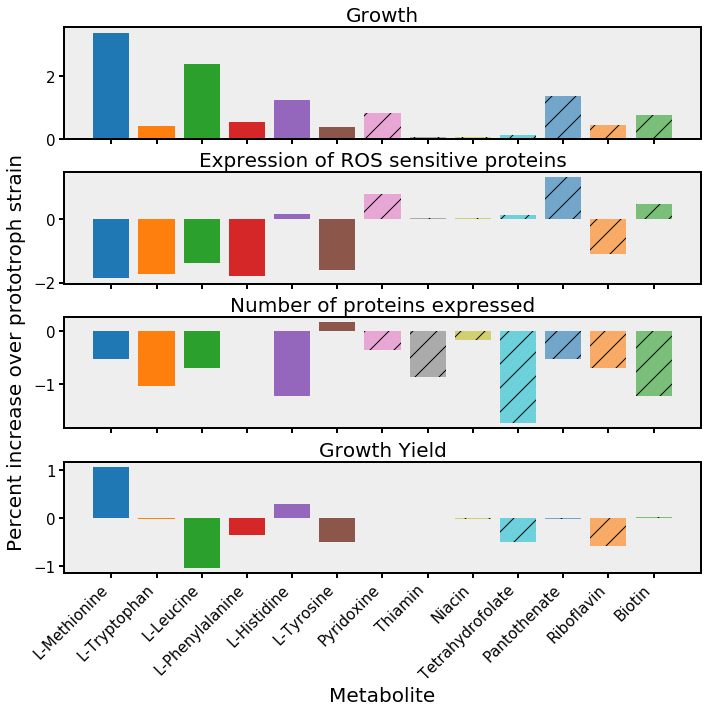

In [13]:
# At max growth
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

i = 0
mets_to_plot = list(df.metabolite[df.metabolite.isin(aas)].unique()) + list(
    df.metabolite[~df.metabolite.isin(aas)].unique())
for met in mets_to_skip:
    mets_to_plot.remove(met)
for met in mets_to_plot:

    temp_df = df[df.metabolite == met]
    
    print(met)
    temp_df.uptake = temp_df.uptake.map(float)
    temp_df.biomass_dilution = temp_df.biomass_dilution.map(float)
    temp_df = temp_df.sort_values('uptake')
    
    alpha = .6 if met not in aas else 1
    hatch = '/' if met not in aas else None
    
    # Plot growth rate
    ax = axes[0]
    ax.bar(i, (return_individual_comparison(temp_df, default_series, at_max=True) - 1) * 100,
          alpha=alpha, hatch=hatch)
    ax.set_title('Growth')
    ax.set_ylabel('Percent increase over prototroph strain           ', ha='right', labelpad=20)
    #ax.set_ylim(bottom=.99)
   
    ax = axes[1]           
    ax.bar(i, (find_flux_through_ros_sensitive_protein(temp_df, default_series, ros_damage_probability, 
                                                       at_max=True) - 1) * 100,
          alpha=alpha, hatch=hatch)
    ax.set_title('Expression of ROS sensitive proteins')
    
    #ax.set_ylim(bottom=.99)
    
    ax = axes[2]
    ax.bar(i, (return_protein_use_comparison(temp_df, default_series, kind='num_proteins_expressed', 
                                             at_max=True) - 1) * 100,
          alpha=alpha, hatch=hatch)
    ax.set_title('Number of proteins expressed')
    
    ax = axes[3]  
    substrate_carbons = me.metabolites.get_by_id(met + '_c').elements['C']
    ax.bar(i, (return_individual_comparison(temp_df, default_series, kind='yield', substrate='EX_'+met+'_c',
                                            substrate_carbons=substrate_carbons, at_max=True) - 1) * 100,
          alpha=alpha, hatch=hatch)
    ax.set_title('Growth Yield')
    ax.set_xlabel('Metabolite', size=20)
    i+=1
    
ax.set_xticks(list(range(0, i)))
ax.set_xticklabels([met_to_name[i] for i in mets_to_plot], rotation=45, ha='right')

fig.tight_layout()
fig.subplots_adjust(hspace = 0.3)
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_mulitme_manuscript/Figures/aux_excess_anaer.png')
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_mulitme_manuscript/Figures/aux_excess_anaer.svg')

## PCA

In [14]:
with open('/home/sbrg-cjlloyd/multime/multime/iJL1678b_ML_keffs.pickle', 'rb') as f:
    me = pickle.load(f)
ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/ecolime/ecolime/building_data/iJO1366.json')

In [15]:

norm_df = cons_df.T / abs(cons_df['biomass_dilution']).T
norm_df[abs(norm_df) < 1e-20] = 0

# only include reactions from above (exclude those filtered in mets to skip)
for i in list(norm_df.columns):
    if '_'.join(i.split("_")[:-1]) in mets_to_skip:
        norm_df.drop(i, axis=1, inplace=True)
    

filter_df = norm_df.copy()
filter_df[abs(filter_df)>0] =1
# TODO why is this <=1 and not == 0
rxns_to_make_zero = filter_df[filter_df.T.sum()  <= 1].index


pca_dict = {}
for met in norm_df.dropna(how='any').columns:
    norm_df.loc[rxns_to_make_zero, met] = 0
    sol = cobra.core.Solution(.1, x_dict=norm_df[met].to_dict(), status='optimal')
    pca_dict[met] = me.get_metabolic_flux(solution=sol)
    

In [16]:
# Create dataframe from above and filter
# Find reactions perfectly correlated across all conditions and remove them from analysis

pca_df = pd.DataFrame(pca_dict)

corr_df = pca_df.T.corr()

corr_df = corr_df.dropna(how='all', axis=0)
corr_df = corr_df.dropna(how='all', axis=1)

correlated_dict = {}
for i in corr_df.columns:
    correlated_set = set()
    correlated_coset = corr_df[i][corr_df[i] > .99]
    if len(correlated_coset) > 1 and i not in [i for sub in correlated_dict.values() for i in sub]:
        correlated_rxns = list(correlated_coset.index)
        correlated_rxns.remove(i)
        correlated_dict[i] = correlated_rxns
        
rxns_to_exclude = [i for sub in correlated_dict.values() for i in sub]

out_df = pca_df.loc[[i for i in pca_df.index if i not in rxns_to_exclude]]
pca_df = out_df.copy()

[0.30021119 0.10199502 0.08560072 0.07467728 0.05363116]
['trp', 'phe', 'leu', 'met', 'tyr', 'his', 'btn', 'nac', 'pnto', 'pydxn', 'ribflv', 'thf', 'thm']


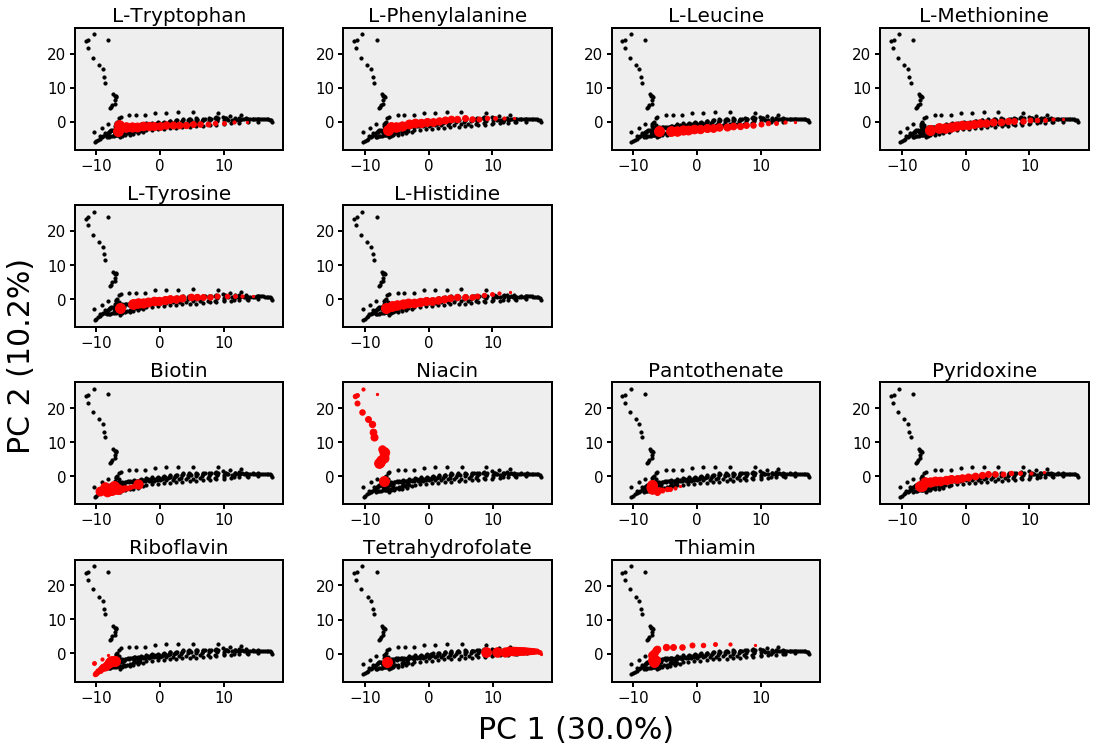

In [17]:
keep_rxns = []
for i in pca_df.index:
    if 'DM_RNA' not in i and not i.startswith('EX_'):
        keep_rxns.append(i)
pca_df = pca_df.T[keep_rxns].T
cons_pca_df = pca_df.copy().T
cons_pca_df = cons_pca_df.loc[[i for i in cons_pca_df.index if 'btn_1.0261601842118495e-07' not in i]]

expression_values = preprocessing.StandardScaler().fit_transform(cons_pca_df)
pca = PCA(n_components=5)
a = pca.fit(expression_values)
len(a.components_[0])


print(pca.explained_variance_ratio_)

rxns =cons_pca_df.columns
#uptake_vals = np.array([float(i.split('_')[-1]) for i in cons_pca_df.index])
X_r = a.transform(expression_values)

component_dict = {}
for comp_num in [0, 1]:
    comp = a.components_[comp_num]
    component_dict['positive_%s' % comp_num] =  dict(zip(rxns[comp > (abs(np.median(comp)) + 2 * comp.std())].values, comp[comp > (abs(comp.mean()) + 2 * comp.std())]))
    component_dict['negative_%s' % comp_num] =  dict(zip(rxns[comp < -(abs(np.median(comp)) + 2 * comp.std())].values, comp[comp < -(abs(comp.mean()) + 2 * comp.std())]))

component_df = pd.DataFrame(component_dict).fillna(0)
for i in component_df.index:
    component_df.loc[i, 'min'] = cons_pca_df.T.loc[i].min()
    component_df.loc[i, 'max'] = cons_pca_df.T.loc[i].max()
    component_df.loc[i, 'avg'] = cons_pca_df.T.loc[i].mean()
    try:
        component_df.loc[i, 'subsystem'] = ijo.reactions.get_by_id(i).subsystem
    except:
        pass
component_df.to_csv('/home/sbrg-cjlloyd/Dropbox/pca_weights/all_test.csv')

mets = set([i.split('_')[0] for i in cons_pca_df.index])
met_order = [i for i in mets if i + '__L' in aas] + sorted([i for i in mets if i+'__L' not in aas])
print(met_order)
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
row = 0
col = -1

def clear_remaining_cols(axes, row, col):
    for new_col in range(col+1, 4):
        axes[row][new_col].axis('off')
for met in met_order:
    for suffix in ['_c', '__L_c', '__R_c']:
        if met+suffix in me.metabolites:
            met_obj = me.metabolites.get_by_id(met+suffix)
    col+=1
    # Move to new row once we hit first cofactor (since sorted should always be biotin)
    if col == 4 or met == 'btn':
        clear_remaining_cols(axes, row, col-1)
        row += 1
        col = 0
    ax = axes[row][col]
    for i, uptake in enumerate(list(change_index_to_uptake_fraction(cons_pca_df.T).index)):#numerate(uptake_vals):
        if met in uptake:
            ax.scatter(X_r[i, 0], X_r[i, 1], c='r', s=100 * float(uptake.split('(')[-1].replace(')', '')),
                      zorder=3)
        else:
        #ax.text(X_r[i, 0], X_r[i, 1], '%.2f' % (uptake / uptake_vals.max()))
            ax.scatter(X_r[i, 0], X_r[i, 1], s=10, c='k')
    ax.set_title(met_to_name[met_obj.id.replace('_c', '')])
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
clear_remaining_cols(axes, row, col)
fig.tight_layout()
fig.text(.5, 0, 'PC 1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100), ha='center', va='top', fontsize=30)
fig.text(0, .5, 'PC 2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100), ha='right', va='center', fontsize=30, rotation=90)
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_mulitme_manuscript/Figures/pca_limitation.png')



## Cluster metabolic flux activity and assess protein allocation

In [18]:
cog_df = pd.read_csv('/home/sbrg-cjlloyd/ecolime/ecolime/characterization/data/cogs_ecoli_mg1655.csv',
                     encoding="ISO-8859-1")
cog_df = cog_df.set_index('locus')
cog_dict = {}
for met in cons_df.index:
    sol = cobra.core.Solution(.1, x_dict=cons_df.loc[met].to_dict(), status='optimal')
    cog_dict[met] = get_protein_distribution(me, solution=sol, cog_df=cog_df, groupby='Metabolic_Subsystem')


2619
2202


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:86 FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:87 FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead


2619
2168
2619
2165
2619
2159
2619
2169
2619
2163
2619
2202
2619
2164
2619
2128
2619
2169


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:524 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2619
2164
2619
2158
2619
2144


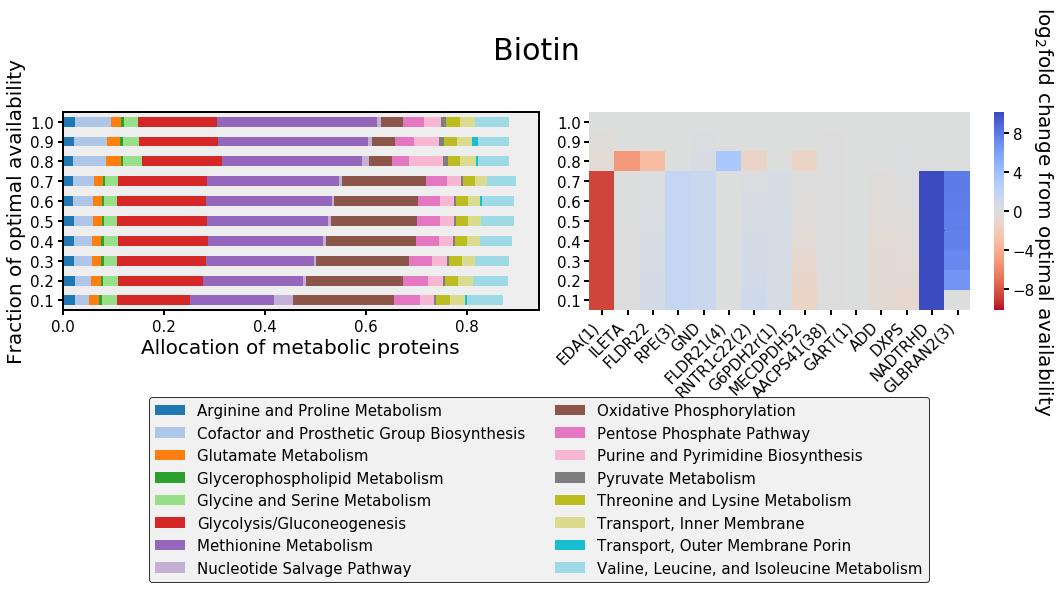

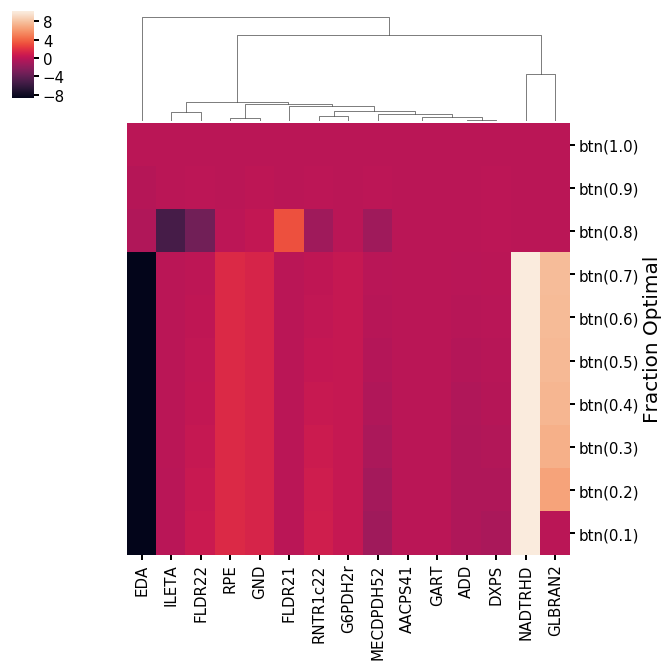

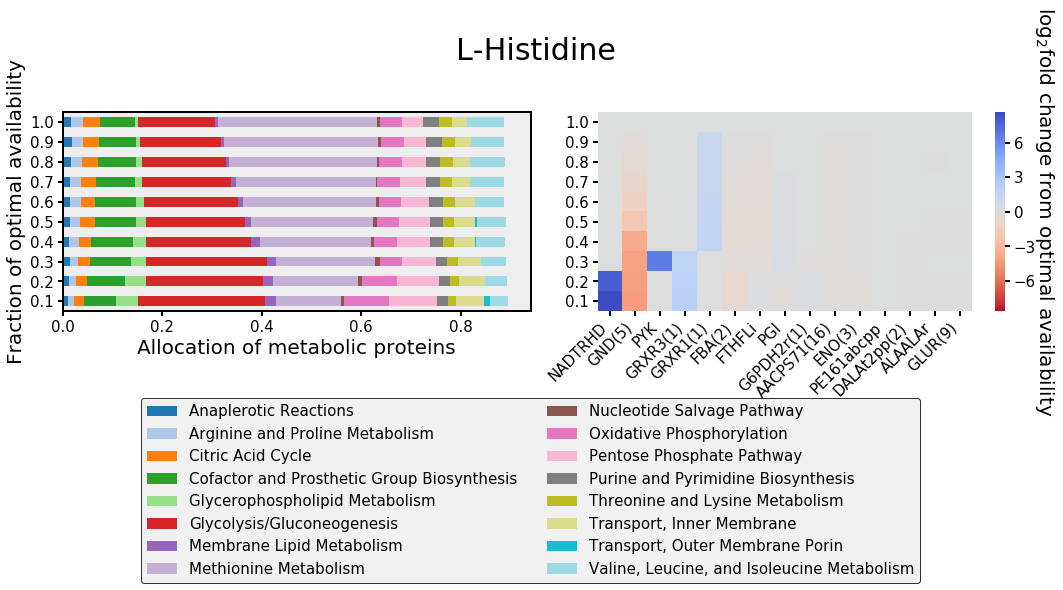

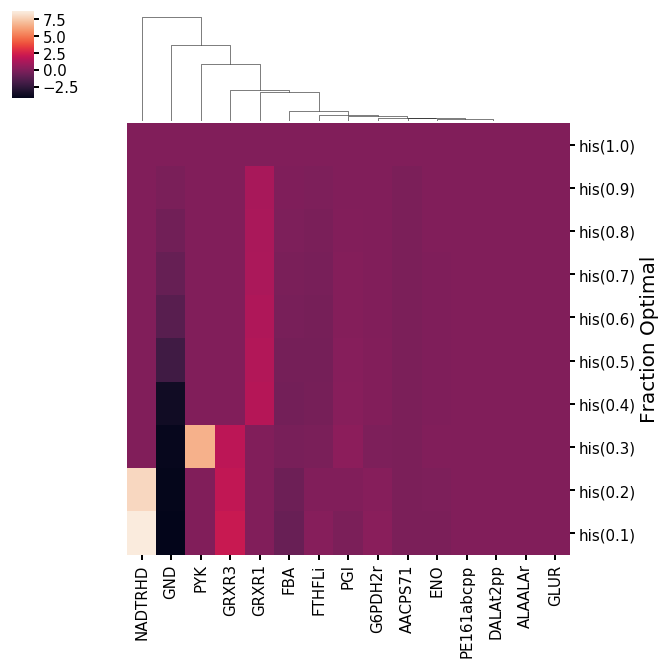

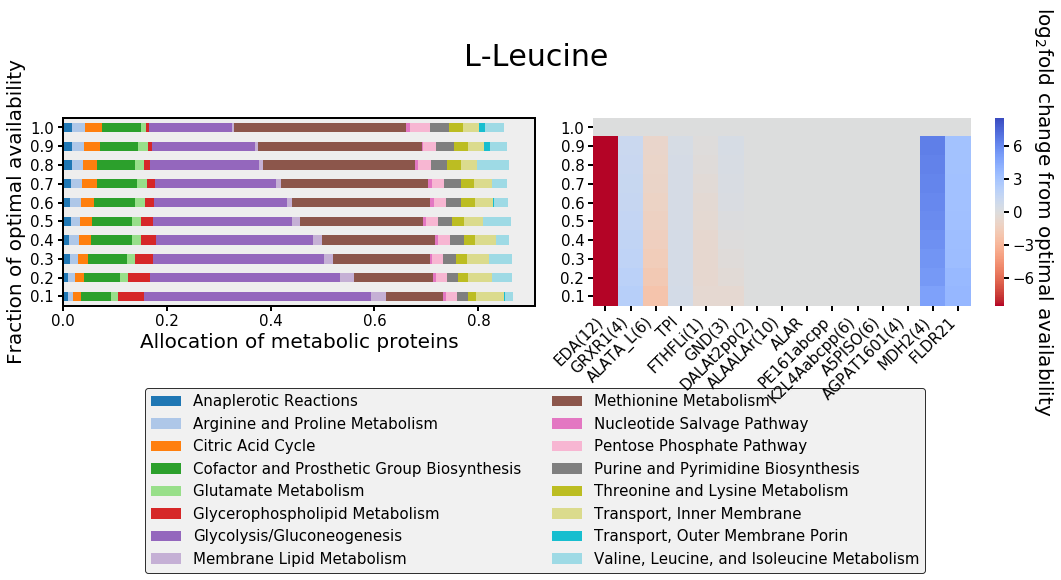

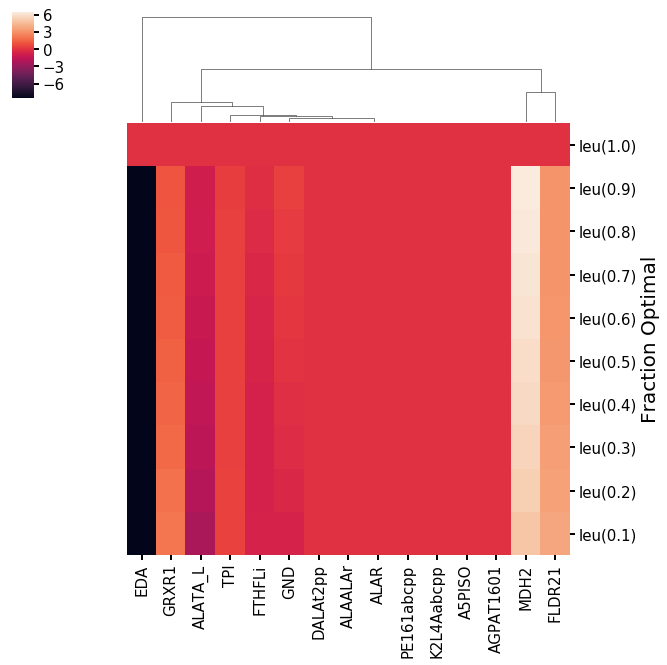

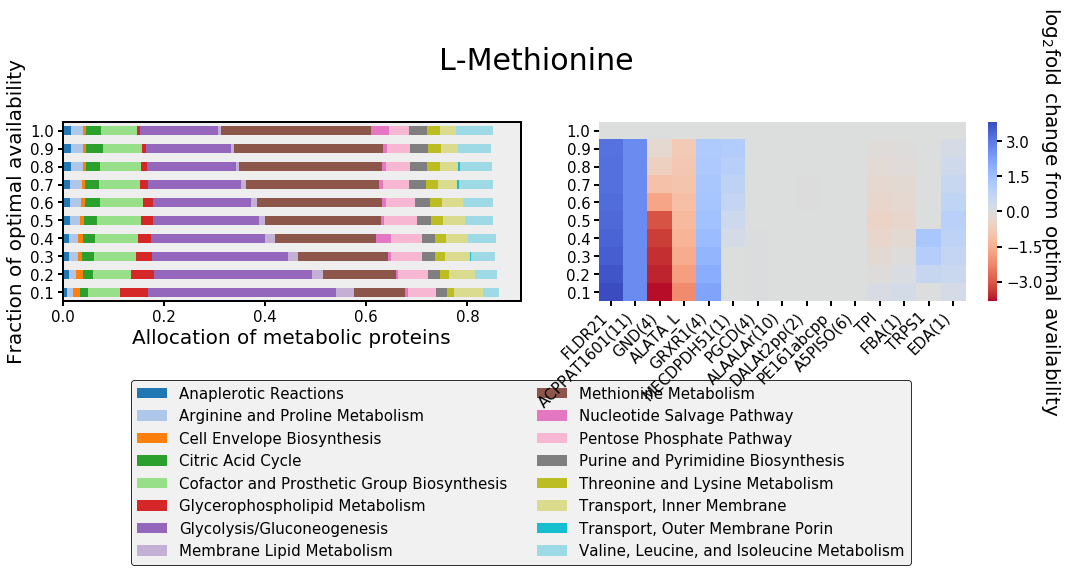

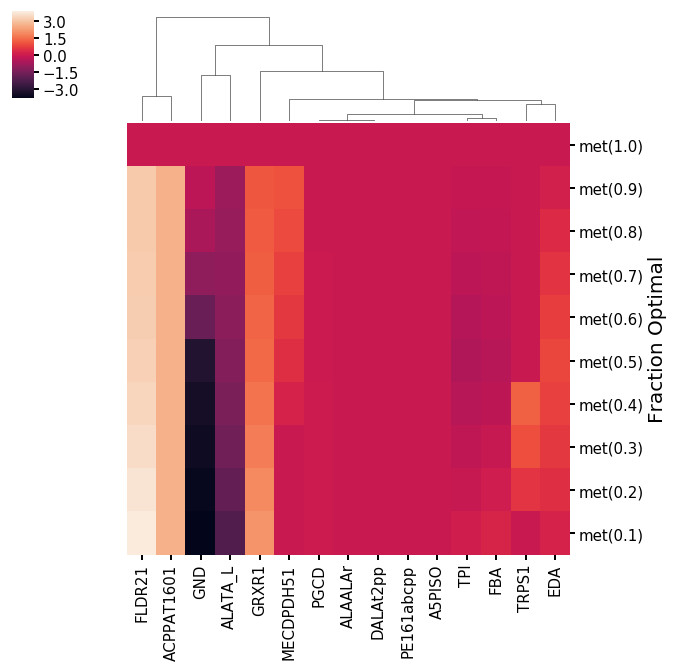

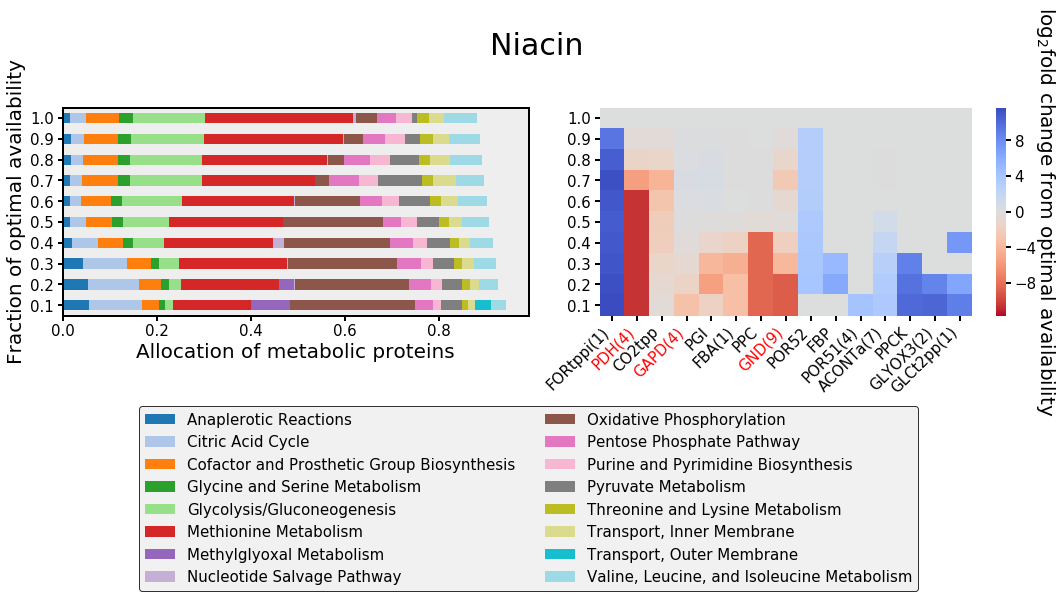

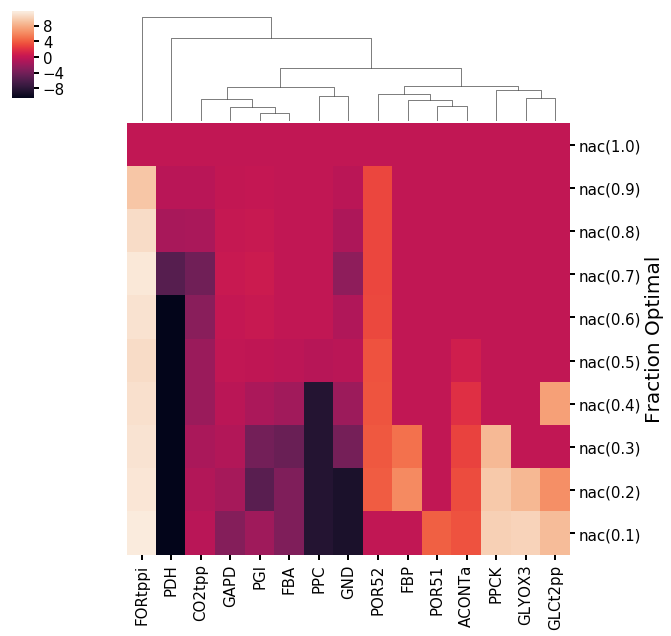

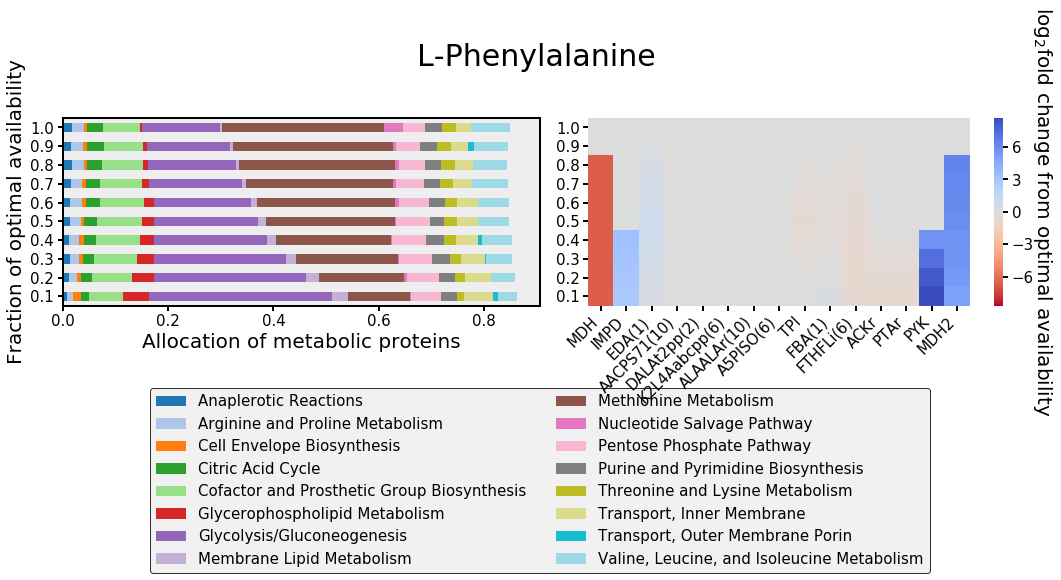

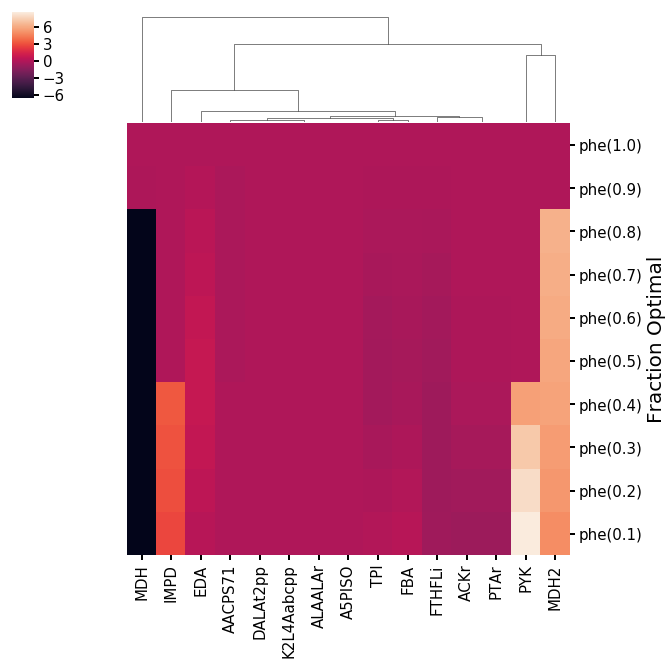

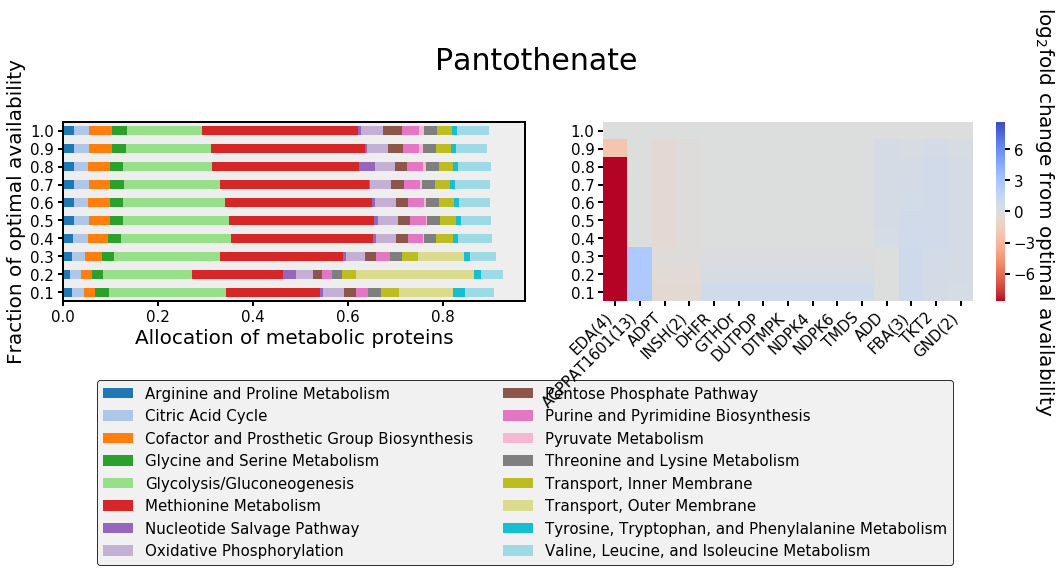

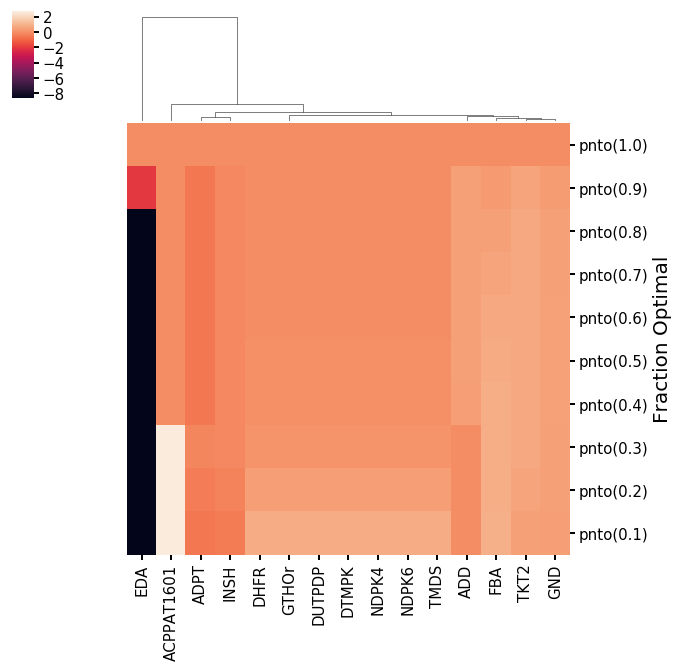

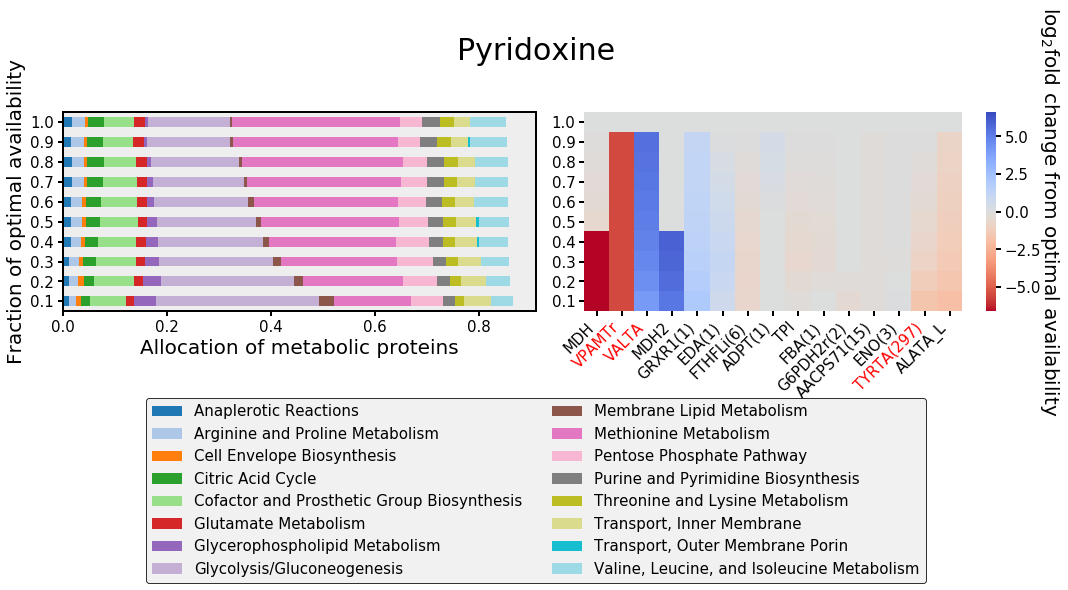

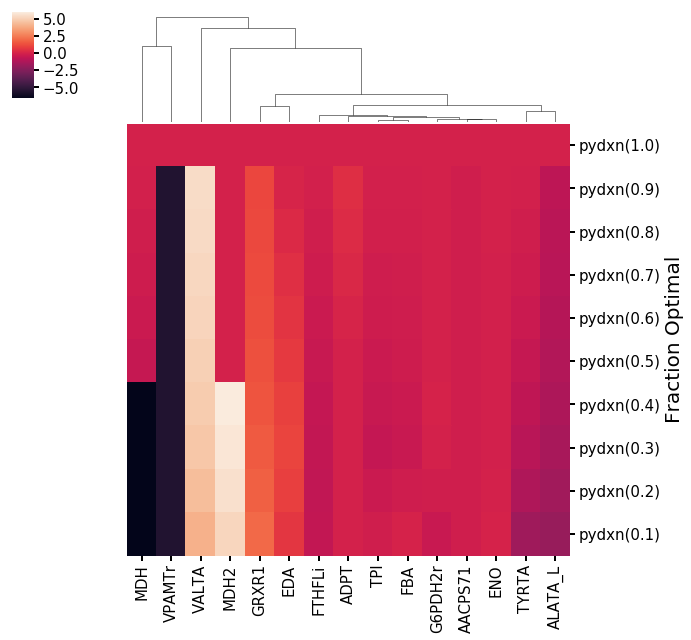

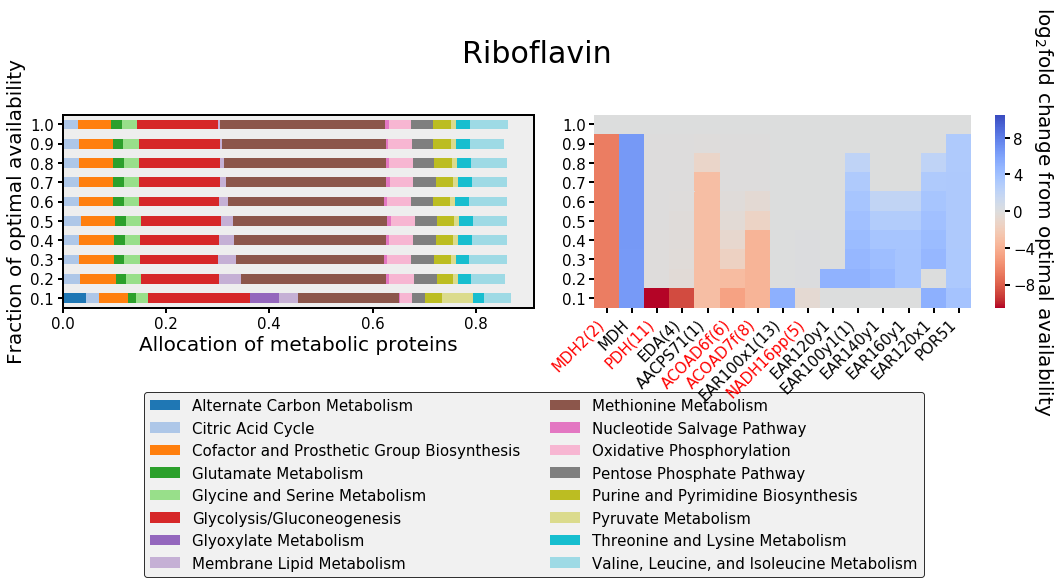

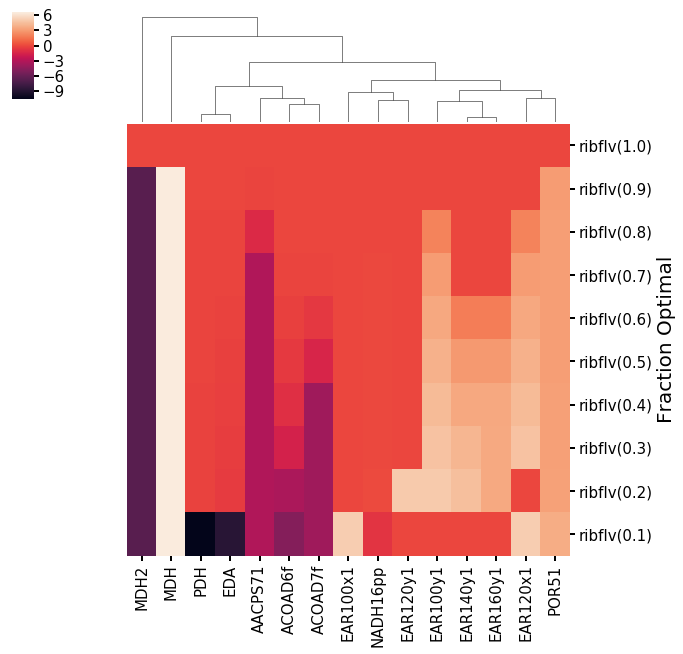

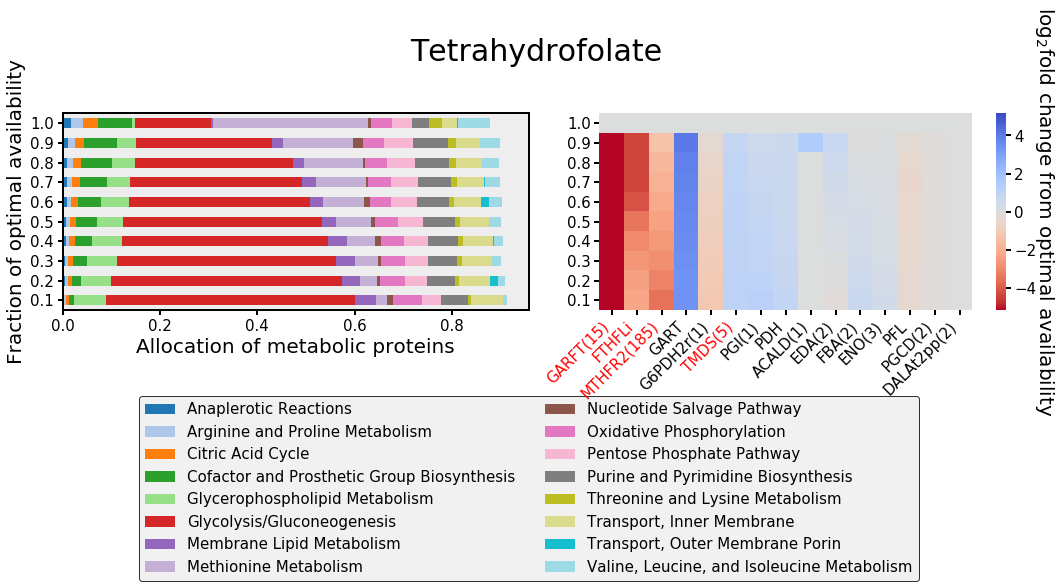

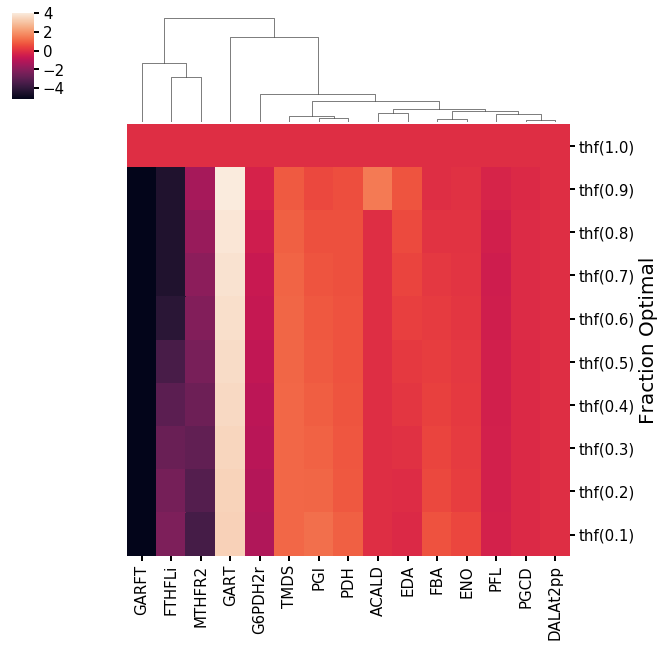

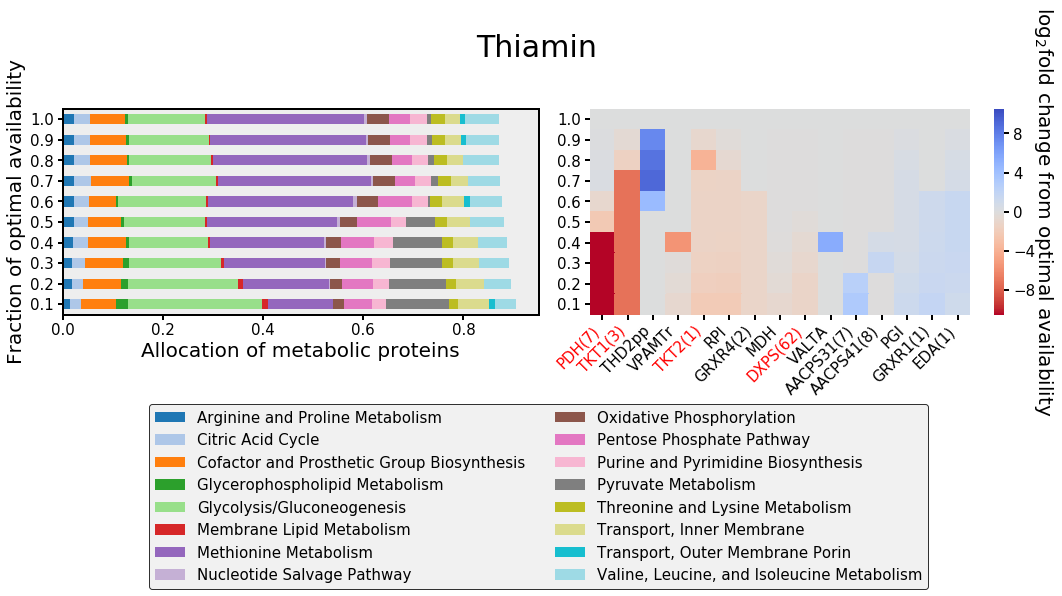

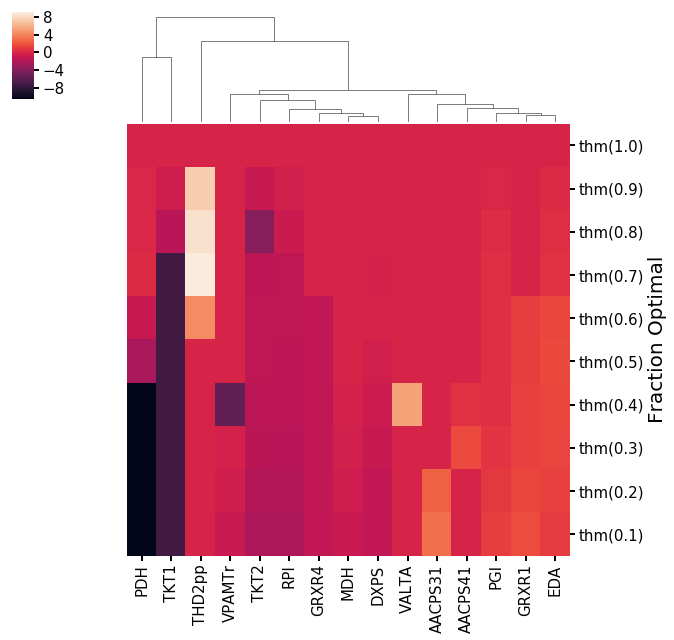

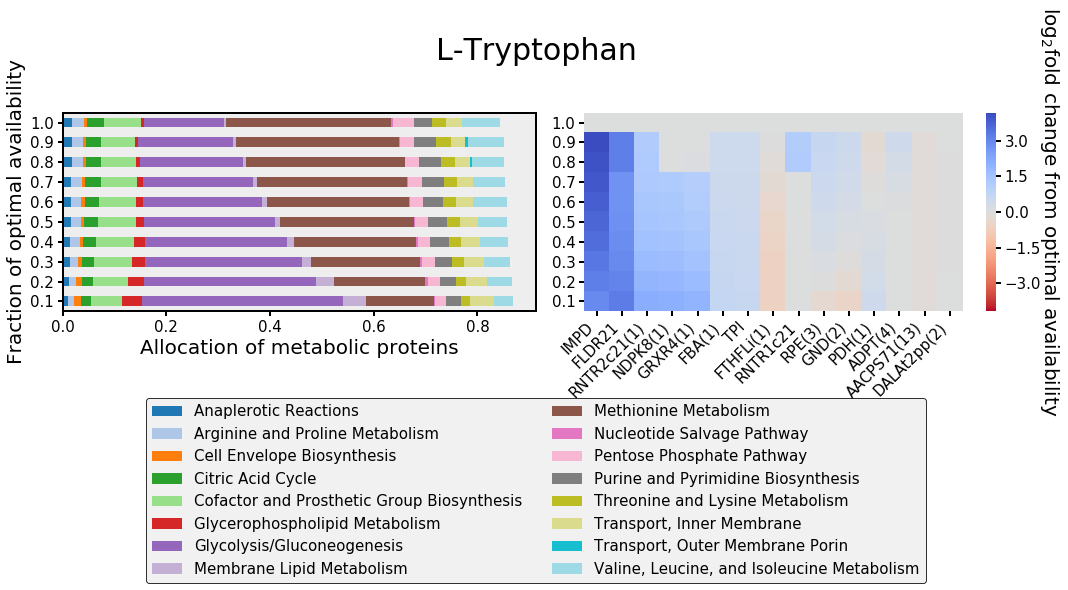

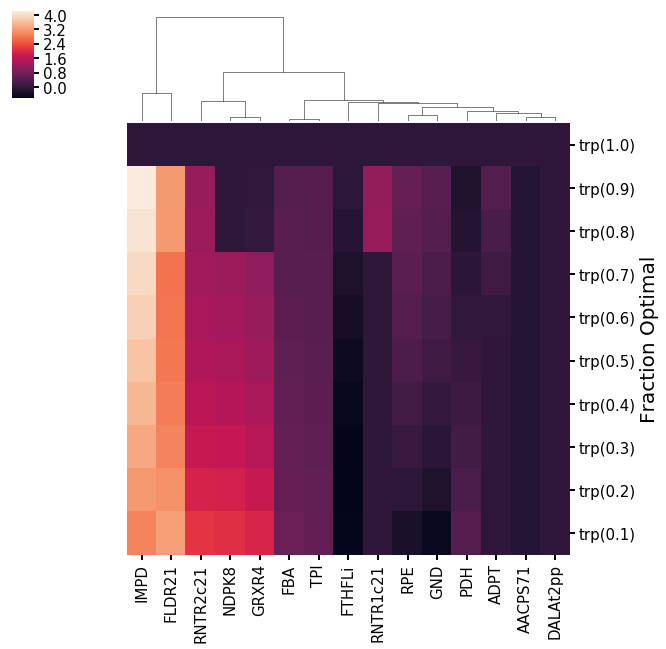

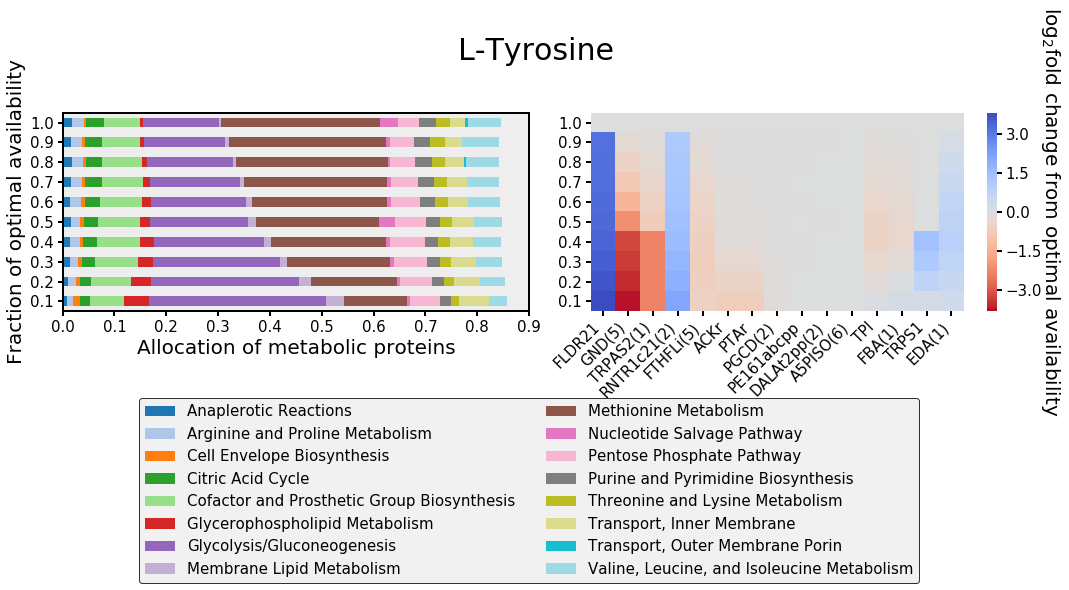

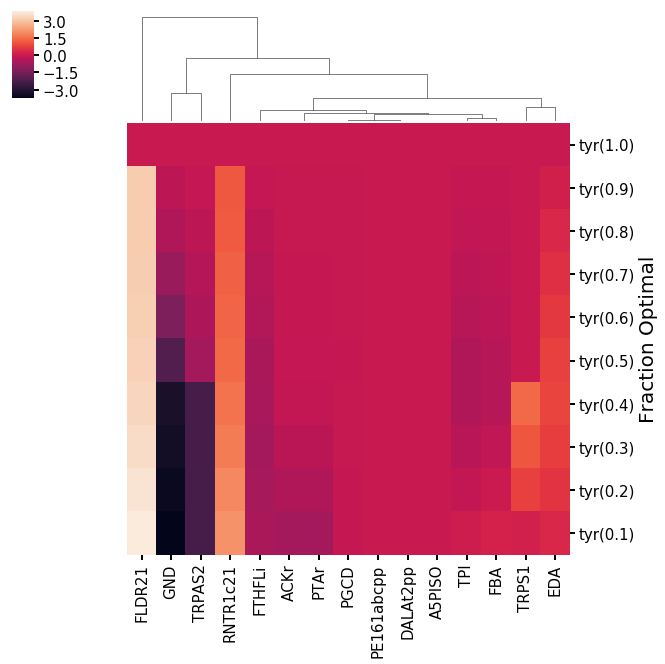

In [19]:
import seaborn as sns

#pca_df = pd.DataFrame(pca_dict)
#pca_df = pca_df.T[[i for i in pca_df.index if 'DM_RNA' not in i]].T


met_to_affected = pd.read_csv('vitamin_to_blocked_reactions.csv',index_col=0).rename(lambda x: x.split(',')[0])
met_to_affected.rename(lambda x: x.replace('nad', 'nac').replace('thmpp', 'thm').replace('pydx5p', 'pydxn'), inplace=True)
def filter_out_correlated_rxns(in_df, met):
    
    try:
        reactions_affected_by_auxotroph = met_to_affected.loc[met].values[0].split(', ')
    except:
        reactions_affected_by_auxotroph = []
    # Find reactions perfectly correlated across all conditions and remove them from analysis
    keep_rxns = []
    for i in in_df.index:
        if 'DM_RNA' not in i:
            keep_rxns.append(i)
    in_df = in_df.T[keep_rxns].T
    
    corr_df = in_df.T.corr()

    corr_df = corr_df.dropna(how='all', axis=0)
    corr_df = corr_df.dropna(how='all', axis=1)

    correlated_dict = {}
    for i in corr_df.columns:
        correlated_set = set()
        correlated_coset = corr_df[i][abs(corr_df[i]) > .99]
        if len(correlated_coset) > 1 and i not in [i for sub in correlated_dict.values() for i in sub]:
            correlated_rxns = list(correlated_coset.index)
            key = None
            for r in correlated_rxns:
                if r in list(reactions_affected_by_auxotroph):
                    key = r
                if r.startswith('EX_') and not key:
                    key = r
                    
            if not key:
                key = correlated_rxns[0]
            if not key.startswith("EX_"):
                correlated_rxns.remove(key)
        
            correlated_dict[key] = correlated_rxns

    rxns_to_exclude = [i for sub in correlated_dict.values() for i in sub]
    print(len(in_df.index))
    out_df = in_df.loc[[i for i in in_df.index if i not in rxns_to_exclude]]
    print(len(out_df.index))
    return out_df, correlated_dict

pca_df = pd.DataFrame(pca_dict)
cons_pca_df = change_index_to_uptake_fraction(pca_df)
for met, a_df in cons_pca_df.groupby('metabolite'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.tight_layout()
    for suffix in ['_c', '__L_c', '__R_c']:
        if met+suffix in me.metabolites:
            met_obj = me.metabolites.get_by_id(met+suffix)
    #s=temp_df.copy()
    temp_df = a_df.copy()
    temp_df.drop('metabolite', axis=1, inplace=True)
    temp_df.sort_values(by='uptake',inplace=True, ascending=False)
    temp_df.drop('uptake', axis=1, inplace=True)
    temp_df, correlated_reaction_dict = filter_out_correlated_rxns(temp_df.T, met)
    temp_df.columns.name = 'Fraction Optimal'
    #temp_df = temp_df.T
    filter_out = []
    cons = temp_df.T[(abs(temp_df.sum()) > 0) & ~ temp_df.columns.isin(filter_out)]
    based_on_activity =False
    log2fc = True
    filter_rxns = []
    if based_on_activity:
        new = cons.copy()
        new[abs(new)>1e-6] = 1
        new[abs(new)<=1e-6] = 0
        # Whether reaction on/off
        new = new.T[(abs(new).sum() > 1) & (abs(new).sum() < len(new.index))].T
        g = sns.clustermap(new, row_cluster=False, figsize=(12, 10), cmap="Blues")
        q = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 
        filter_rxns = []#list(new.columns)
    if log2fc:
        new = cons.copy()
        new = abs(new)
        new = new.clip_lower(1e-2)
        new = new.clip_upper(100)
        new = new.T[~new.columns.isin(filter_rxns)].T
        new = new.applymap(log2) - new.iloc[0].map(log2)
        new = new[abs(new).std(axis=0).sort_values(ascending=False).iloc[:15].index.values]
        #new = new.T[abs(new).std(axis=0) > (abs(new).std(axis=0).median() + .5 * abs(new).std(axis=0).std())].T
        new = new.T[[i for i in new.index if float(i.split('(')[1].split(')')[0])*10 % 1 ==0]].T
        
        cluster = sns.clustermap(new, row_cluster=False)
        max_val = abs(cluster.data2d).max().max()
        g = sns.heatmap(cluster.data2d, ax=axes[1], cmap="coolwarm_r", vmin=-max_val, vmax=max_val)
        g.collections[0].colorbar.set_label(r'log$_2$fold change from optimal availability', rotation=270,
                                    labelpad=20)
        
        q = plt.setp(g.get_yticklabels(), rotation=0) 
        #g.cax.set_title('Log2 Fold Change')
        try:
            reactions_affected_by_auxotroph = met_to_affected.loc[met].values[0].split(', ')
        except:
            reactions_affected_by_auxotroph = []
        new_labels = []
        for tick in g.get_xticklabels():
            old_text = tick.get_text()
            tick.set_rotation(45)
            tick.set_size(15)
            tick.set_horizontalalignment('right')
            if old_text  in reactions_affected_by_auxotroph:
                tick.set_color('r')
            if old_text in correlated_reaction_dict:
                new_text = old_text + '(%i)' % len(correlated_reaction_dict[old_text])
                new_labels.append(new_text)
            else:
                new_labels.append(old_text)
        g.set_xticklabels(new_labels)
                
        g.set_ylabel('', rotation=90)
        g.set_yticklabels([i.get_text().split('(')[1].split(")")[0] for i in g.get_yticklabels()])
    else:
        new = cons.copy()
        new = abs(nebw)
        new = new.clip_lower(1e-5)
        new = new.clip_upper(10)
        #new = new.applymap(log10)
        new = new.T[~new.columns.isin(filter_rxns)].T
        # By variation
        new = new.T[abs(new).std(axis=0) > (abs(new).std(axis=0).median() + .5* abs(new).std(axis=0).std())].T
        g = sns.clustermap(new, row_cluster=False, figsize=(12, 10), cmap="Blues")
        q = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    
    
    # Barchart of COG allocation
    cog_df = pd.DataFrame(cog_dict)
    cog_df = cog_df / cog_df.sum()

    cog_df = change_index_to_uptake_fraction(cog_df).drop(['metabolite', 'uptake'], axis=1).T
    cog_df.columns.name = ''
    temp = cog_df.fillna(0)
    temp = temp[[i for i in temp.columns if met in i]]
    temp = temp[abs(temp).std(axis=1) > (abs(temp).std(axis=1).median() + 0 * abs(temp).std(axis=1).std())]
    temp = temp[[i for i in temp.columns if float(i.split('(')[1].split(')')[0])*10 % 1 ==0]] 
    ax = temp.T.plot(kind='barh', stacked=True, cmap='tab20', ax=axes[0])

    ax.set_ylabel('Fraction of optimal availability', size=20)
    ax.set_yticklabels([i.get_text().split('(')[1].split(")")[0] for i in ax.get_yticklabels()])
    ax.set_xlabel('Allocation of metabolic proteins', size=20)
    ax.figure.tight_layout()
    ax.figure.text(.5, 1.04, met_to_name[met_obj.id.replace('_c', '')], ha='center', va='top', fontsize=30)
    lgd = ax.legend(fontsize=15, ncol=2, bbox_to_anchor=(1,-.4), loc='upper center')
    fig.savefig('/home/sbrg-cjlloyd/Dropbox/_mulitme_manuscript/Figures/%s.png' % met, 
                bbox_extra_artists=(lgd,), bbox_inches='tight')

In [132]:
import math
# Get growth-normalized cog df for the default model
aas = ['phe(1.0)', 'his(1.0)', 'tyr(1.0)', 'met(1.0)', 'trp(1.0)', 'leu(1.0)']
cofs = ['pydxn(1.0)', 'thm(1.0)', 'nac(1.0)', 'thf(1.0)', 
       'pnto(1.0)', 'ribflv(1.0)', 
       'btn(1.0)']

cog_df = pd.DataFrame(cog_dict)
cog_df = change_index_to_uptake_fraction(cog_df).drop(['metabolite', 'uptake'], axis=1).T
cog_df.columns.name = ''

cog_annot_df = pd.read_csv('/home/sbrg-cjlloyd/ecolime/ecolime/characterization/data/cogs_ecoli_mg1655.csv',
                     encoding="ISO-8859-1")
cog_annot_df = cog_annot_df.set_index('locus')
default_cog_dict = {}
sol = cobra.core.Solution(.1, x_dict=default_series.to_dict(), status='optimal')
default_cog_dict['default'] = get_protein_distribution(me, solution=sol, cog_df=cog_annot_df, groupby='Metabolic_Subsystem')
default_cog_df = pd.DataFrame.from_dict(default_cog_dict) / default_series['biomass_dilution']

In [170]:
all_df = pd.DataFrame()
for i in cog_df[[i for i in cog_df.columns if '1.0' in i]].columns:
    cog_norm_df = cog_df[i] / change_index_to_uptake_fraction(cons_df.T).loc[i, 'biomass_dilution']
    diff_df = (cog_norm_df.map(math.log2) - default_cog_df['default'].map(math.log2)).fillna(0)
    diff_df.name = i
    all_df = all_df.append(diff_df)
    #diff_df[abs(diff_df)>.5].plot(kind='bar', ax=ax)
    #ax.set_title(i)
all_df.drop('Transport, Outer Membrane Porin', inplace=True, axis=1)



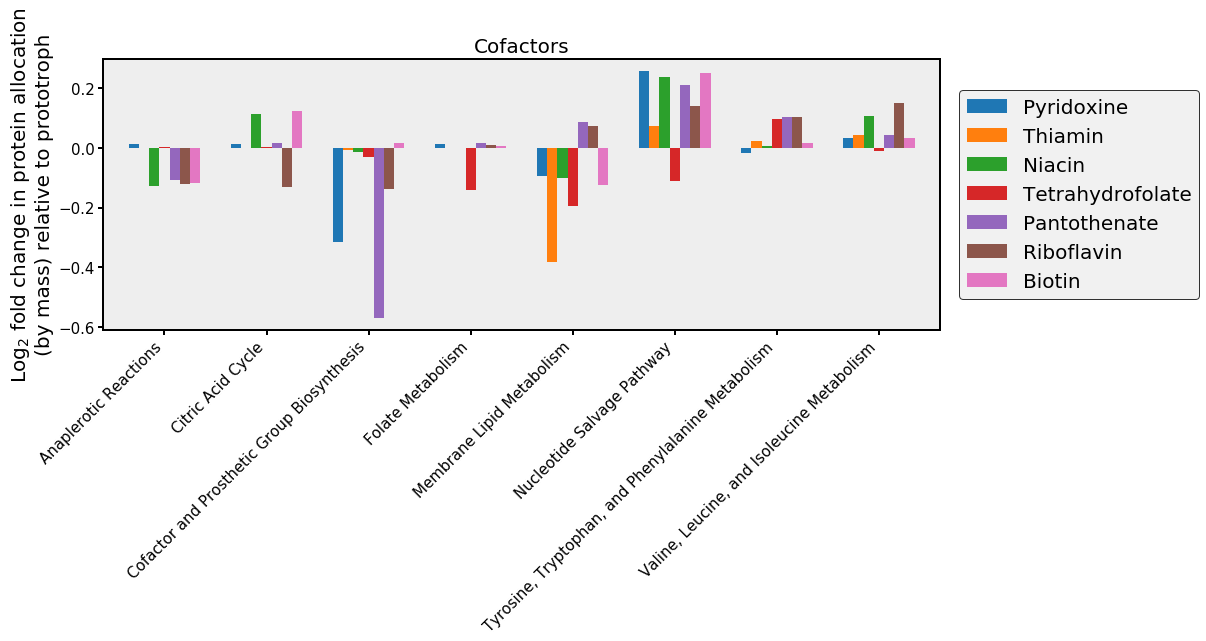

In [187]:
cols_to_use = all_df.loc[cofs][abs(all_df.loc[cofs])>.1].dropna(how='all', axis=1).columns
filt_df = all_df.loc[cofs][cols_to_use]
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0], x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__L', x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__R', x))
ax = filt_df.T.plot(kind='bar', width=.7)
ax.legend(bbox_to_anchor=(1.01,.5), loc='center left')
ax.set_ylabel(r'Log$_2$ fold change in protein allocation'+ '\n(by mass) relative to prototroph')
ax.set_title('Cofactors')
_ =ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

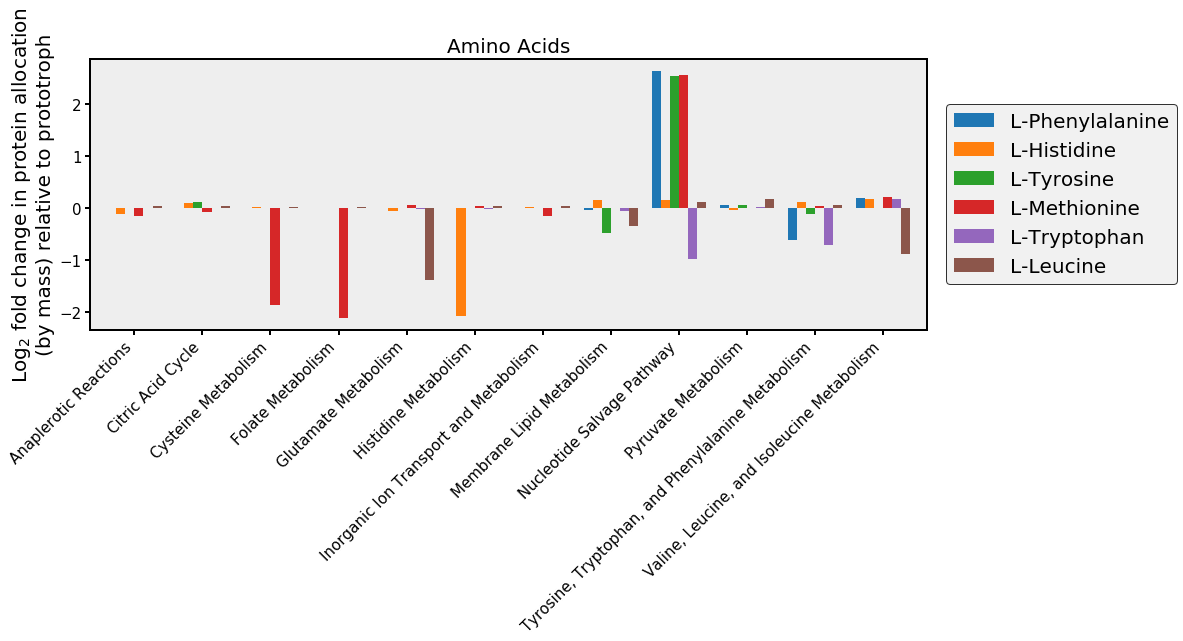

In [188]:
cols_to_use = all_df.loc[aas][abs(all_df.loc[aas])>.1].dropna(how='all', axis=1).columns
filt_df = all_df.loc[aas][cols_to_use]
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0], x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__L', x))
filt_df = filt_df.rename(lambda x: met_to_name.get(x.split('(')[0] + '__R', x))
ax=filt_df.T.plot(kind='bar', width=.8)
ax.legend(bbox_to_anchor=(1.01,.5), loc='center left')
ax.set_ylabel(r'Log$_2$ fold change in protein allocation'+ '\n(by mass) relative to prototroph')
ax.set_title('Amino Acids')
_ =ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [200]:
met_rs = []
sol = cobra.core.Solution(1, x_dict=default_series.to_dict(), status='optimal')
default_fluxes = me.get_metabolic_flux(solution=sol)
for r in ijo.reactions:
    if r.subsystem == 'Nucleotide Salvage Pathway':
        try:
            print(r.id, r.reaction, cons_pca_df.loc['met(1.0)', r.id], default_fluxes[r.id])
        except:
            pass
        try:
            print(r.id, r.reaction, cons_pca_df.loc['met(1.0)', r.id+'1'], default_fluxes[r.id+'1'])
        except:
            pass 
        try:
            print(r.id, r.reaction, cons_pca_df.loc['met(1.0)', r.id+'2'], default_fluxes[r.id+'2'])
        except:
            pass
        met_rs.append(r.id)

23PDE2pp 23cump_p + h2o_p --> 3ump_p + h_p 0.0 0.0
23PDE4pp 23ccmp_p + h2o_p --> 3cmp_p + h_p 0.0 0.0
23PDE7pp 23camp_p + h2o_p --> 3amp_p + h_p 0.0 0.0
23PDE9pp 23cgmp_p + h2o_p --> 3gmp_p + h_p 0.0 0.0
3AMACHYD 3amac_c + h2o_c + h_c --> msa_c + nh4_c 0.0 0.0
3NTD2pp 3ump_p + h2o_p --> pi_p + uri_p 0.0 0.0
3NTD4pp 3cmp_p + h2o_p --> cytd_p + pi_p 0.0 0.0
3NTD7pp 3amp_p + h2o_p --> adn_p + pi_p 0.0 0.0
3NTD9pp 3gmp_p + h2o_p --> gsn_p + pi_p 0.0 0.0
ADA adn_c + h2o_c + h_c --> ins_c + nh4_c 0.0 0.0
ADD ade_c + h2o_c + h_c --> hxan_c + nh4_c 0.014312495942540802 0.01205428069429904
ADK1 amp_c + atp_c <=> 2.0 adp_c 8.41143378569267 7.352565000540668
ADK3 amp_c + gtp_c <=> adp_c + gdp_c 0.0 0.0
ADK4 amp_c + itp_c <=> adp_c + idp_c 0.0 0.0
ADNCYC atp_c --> camp_c + ppi_c 0.0 0.0
ADNK1 adn_c + atp_c --> adp_c + amp_c + h_c 0.0 0.0
ADPRDP adprib_c + h2o_c --> amp_c + 2.0 h_c + r5p_c 0.0 0.0
ADPT ade_c + prpp_c --> amp_c + ppi_c 0.0 0.0
AMPN amp_c + h2o_c --> ade_c + r5p_c 0.0 0.0
AP4AH ap4a_

In [ ]:
me.reactions.RNDR4

In [106]:
df

In [80]:
import seaborn as sns
pca_df = pd.DataFrame(pca_dict)
pca_df = pca_df.T[[i for i in pca_df.index if 'DM_RNA' not in i]].T
cons_pca_df = pca_df.copy()
cons_pca_df = cons_pca_df.T
cons_pca_df['metabolite'] = list(cons_pca_df.index)
cons_pca_df['uptake'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[-1]).map(float)
cons_pca_df['metabolite'] = cons_pca_df['metabolite'].map(lambda x: x.split('_')[0])
cons_pca_df = cons_pca_df.drop('metabolite', axis=1)
cons_pca_df = cons_pca_df.T[abs(cons_pca_df.sum())>0]
cons_pca_df = abs(cons_pca_df)
cons_pca_df = cons_pca_df.clip_lower(1e-5).applymap(log10)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:12 FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


In [85]:
corr_df = cons_pca_df[[i for i in cons_pca_df.columns if '_'.join(i.split('_')[:-1]) not in aas]]

In [98]:
import escher
view = escher.Builder("iJO1366.Central metabolism")
view.reaction_data =  [cons_pca_df.loc['thf(1.0)'].to_dict()]
view.model = ijo

view.display_in_notebook()